# Identifiability confusion matrices


In [25]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd


import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils


In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [27]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

optimal_k_fit_N_array = np.array([4, 0, 3, 0]).astype(int)


optimal_fit_N_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_mu_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)

for k_fit_scheme in range(n_schemes - 1):    # We exclude rate coding
    optimal_fit_N_array[k_fit_scheme] = N_array[optimal_k_fit_N_array[k_fit_scheme]]    # Optimal N
    # Now we fill values for optimal mu and t
    if k_fit_scheme % 2 == 0:    # Gaussian case
        t_mu_tmp = t_mu_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        t_conf_tmp = t_conf_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_mu_array[k_fit_scheme] = t_mu_tmp
        optimal_t_conf_array[k_fit_scheme] = t_conf_tmp
    else:
        optimal_t_mu_array[k_fit_scheme] = t_mu_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_conf_array[k_fit_scheme] = t_conf_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]

# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# Rate coding scaling parameters between probability and confidence neurons
mu_sd = 0.219    # Std of the signal of mu's
conf_sd = 0.284    # Std of the signal of conf's

# The number of possible N
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 1000

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12
max_n_local_regular_stimuli = 18

# Transition proba or Bernoulli proba
distrib_type = 'bernoulli'

# Load the corresponding data
[p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli,
                                                                                      distrib_type)


# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner

between_scans_duration = 2  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


# Type of regression
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)
regr2 = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)

whitening_done = False


In [28]:
# Just for now
n_subjects = 2
n_sessions = 4
n_schemes = 5


In [29]:
# Create X

# Initialization of the design matrices and their zscore versions
X = [[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_scheme in range(n_schemes)]

### WE BEGIN BY CREATING THE DESIGN MATRIX X
start = time.time()

for k_subject in range(n_subjects):
    ### Loop over the sessions : we start with it in order to have the same length whatever N_fit is
    for k_session in range(n_sessions):
        # Get the data of interest
        mu = p1_mu_array[k_subject, k_session, :n_stimuli]
        sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
        conf = -np.log(sigma)
        dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]

        # Formatting
        simulated_distrib = [None for k in range(n_stimuli)]
        for k in range(n_stimuli):
            # Normalization of the distribution
            norm_dist = dist[:, k] * (len(dist[1:, k]) - 1) / np.sum(dist[1:, k])
            simulated_distrib[k] = distrib(mu[k], sigma[k], norm_dist)

        # Experimental design information
        eps = 1e-5  # For floating points issues
        initial_time = between_stimuli_duration + eps
        final_time_tmp = between_stimuli_duration * (n_stimuli + 1) + eps
        # Every 15+-3 trials : one interruption of 8-12s
        stimulus_onsets = np.linspace(initial_time, final_time_tmp, n_stimuli)
        # We add some time to simulate breaks
        stimulus = 0

        while True:
            # Number of regularly spaced stimuli
            n_local_regular_stimuli = rand.randint(min_n_local_regular_stimuli, max_n_local_regular_stimuli)
            stimulus_shifted = stimulus + n_local_regular_stimuli  # Current stimulus before the break
            if stimulus_shifted > n_stimuli:  # The next break is supposed to occur after all stimuli are shown
                break
            stimulus_onsets[stimulus_shifted:] += rand.randint(min_break_time,
                                                               max_break_time) - between_stimuli_duration  # We consider a break of 8-12s
            stimulus = stimulus_shifted

        stimulus_durations = dt * np.ones_like(stimulus_onsets)  # Dirac-like stimuli

        # fMRI information
        final_time = stimulus_onsets[-1]
        final_frame_time = final_time + final_frame_offset

        initial_scan_time = initial_frame_time + between_scans_duration
        final_scan_time = final_time + final_scan_offset
        scan_times = np.arange(initial_scan_time, final_scan_time, between_scans_duration)

        # Creation of fmri object
        simu_fmri = fmri(initial_frame_time, final_frame_time, dt, scan_times)

        # Creation of experiment object
        exp = experiment(initial_time, final_time, n_sessions, stimulus_onsets, stimulus_durations, simulated_distrib)

        ### LOOP OVER THE SCHEME
        for k_fit_scheme in range(n_schemes):

            # Current schemes
            fit_scheme = scheme_array[k_fit_scheme]

            # We replace the right value of the "t"'s according to the type of tuning curve and the N
            if fit_scheme.find('gaussian') != -1:
                fit_N = optimal_fit_N_array[k_fit_scheme]
                fit_t_mu = optimal_t_mu_array[k_fit_scheme]
                fit_t_conf = optimal_t_conf_array[k_fit_scheme]

                fit_tc_type = 'gaussian'
                # Creation of the true tuning curve objects
                fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                             tc_upper_bound_conf)

            elif fit_scheme.find('sigmoid') != -1:
                fit_N = optimal_fit_N_array[k_fit_scheme]
                fit_t_mu = optimal_t_mu_array[k_fit_scheme]
                fit_t_conf = optimal_t_conf_array[k_fit_scheme]

                fit_tc_type = 'sigmoid'
                # Creation of the true tuning curve objects
                fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                             tc_upper_bound_conf)

            if fit_scheme.find('ppc') != -1:
                fit_tc = [fit_tc_mu, fit_tc_conf]
            elif fit_scheme.find('dpc') != -1:
                fit_tc = [fit_tc_mu]
            elif fit_scheme.find('rate') != -1:
                fit_tc = []

            # Regressor and BOLD computation
            X[k_fit_scheme][k_subject][k_session] = simu_fmri.get_regressor(exp, fit_scheme, fit_tc)
            
            
            # Rescale the regressors for rate code
            if fit_scheme.find('rate') != -1:
                X[k_fit_scheme][k_subject][k_session][:, 1] = mu_sd/conf_sd * X[k_fit_scheme][k_subject][k_session][:, 1]            

    end = time.time()
    if k_subject % 10 ==0:
        print('Design matrix creation : Subject n'+str(k_subject)+' is done ! Time elapsed : '+str(end-start)+'s')

Design matrix creation : Subject n0 is done ! Time elapsed : 0.23833179473876953s


## Handle the data

### Row data loading and visualization


X of size : (365, 2)
Scheme : rate
Subject n°0
Session n°3



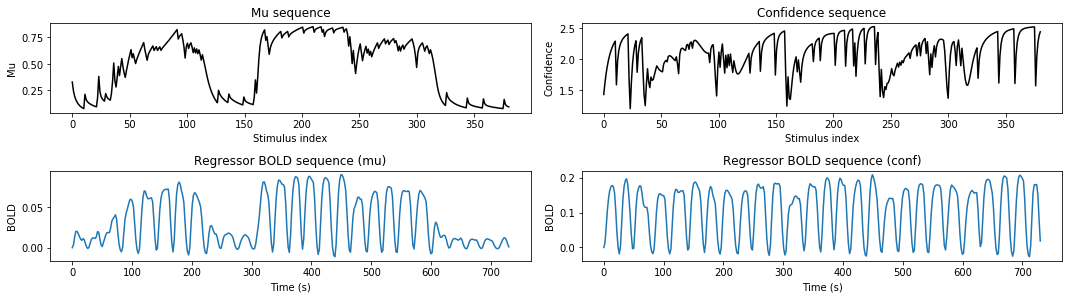

In [30]:
# Plot signal compared to summary statistics for the desired model
######################################################################################
k_fit_scheme = 4
k_subject = 0
k_session = 3
n_stimuli = 380
#######################################################################################
# Tuning curve indices to visualize
i_mu = 1
i_conf = 0

# Test everything is fine
mu = p1_mu_array[k_subject, k_session, :n_stimuli]
sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
conf = -np.log(sigma)
dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]


fit_scheme = scheme_array[k_fit_scheme]
print('X of size : '+str(X[k_fit_scheme][k_subject][k_session].shape))
data_signal_mu = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, i_mu])
print('Scheme : '+fit_scheme)
print('Subject n°'+str(k_subject))
print('Session n°'+str(k_session)+'\n')

n_scans = X[k_fit_scheme][k_subject][k_session].shape[0]


if k_fit_scheme < 4:    # PPC or DPC
    # For gaussian PPC
    fit_N = int(optimal_fit_N_array[k_fit_scheme])

    # For gaussian PPC
    if fit_scheme.find('gaussian')!=-1:
        tc_type = 'gaussian'
    elif fit_scheme.find('sigmoid')!=-1:
        tc_type = 'sigmoid'

    # For mu
    t_mu = optimal_t_mu_array[k_fit_scheme]

    tc_mu = tuning_curve(tc_type, fit_N, t_mu, tc_lower_bound_mu, tc_upper_bound_mu)

    tc_signal_mu =  tc_mu.f(mu, i_mu)

    print('N='+str(fit_N))
    print('Tuning curve n°'+str(i_mu)+' related to mu')

    
    # for color plots of all tuning curves
    data_mu = np.zeros((fit_N, n_scans))
    for idx_mu in range(fit_N):
        data_mu[idx_mu, :] = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, idx_mu])

    # Only if we ask for PPC we display confidence plots
    if fit_scheme.find('ppc')!=-1:
        # For gaussian PPC
        if fit_scheme.find('gaussian')!=-1:
            tc_type = 'gaussian'
        elif fit_scheme.find('sigmoid')!=-1:
            tc_type = 'sigmoid'
            
        t_conf = optimal_t_conf_array[k_fit_scheme]
        tc_conf = tuning_curve(tc_type, fit_N, t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

        tc_signal_conf =  tc_conf.f(conf, i_conf)
        print('X of size : '+str(X[k_fit_scheme][k_subject][k_session].shape))
        data_signal_conf = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, fit_N+i_conf])

        data_conf = np.zeros((fit_N, n_scans))
        for idx_conf in range(fit_N):
            data_conf[idx_conf, :] = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, fit_N+idx_conf])

        bold_max = np.max(X[k_fit_scheme][k_subject][k_session].flatten())
        
        print('Scheme : '+scheme_array[k_fit_scheme])
        print('N='+str(fit_N))
        print('Subject n°'+str(k_subject))
        print('Session n°'+str(k_session)+'\n')
        print('Tuning curve n°'+str(i_conf)+' related to the confidence')
else:
    data_signal_mu = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, 0])
    data_signal_conf = copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, 1])

### VISUALIZATION

fig = plt.figure(figsize=(15, 10))

# Mu sequence

ax1_up = fig.add_subplot(521)
ax1_up.plot(np.linspace(0, len(mu), len(mu)), mu, color='black')
ax1_up.set_xlabel('Stimulus index')
ax1_up.set_ylabel('Mu')
ax1_up.set_title('Mu sequence')

if k_fit_scheme < 4:    # PPC or DPC

    # Tuning curves
    ax1_down = fig.add_subplot(523)
    mu = np.linspace(tc_lower_bound_mu, tc_upper_bound_mu, 1000)
    tc_color = [None for k in range(fit_N)]
    for k in range(fit_N):
        p = ax1_down.plot(mu, tc_mu.f(mu, k))
        tc_color[k] = p[0].get_color()
    ax1_down.set_xlabel('Mu')
    ax1_down.set_ylabel('Average firing rate')
    ax1_down.set_title('Tuning curves for mu')

    # Tuning curve value sequence
    ax_up = fig.add_subplot(525)
    ax_up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_mu, color=tc_color[i_mu])
    ax_up.set_xlabel('Stimulus index')
    ax_up.set_ylim(0, 1)
    ax_up.set_ylabel('Tuning curve n°'+str(i_mu)+' value')
    ax_up.set_title('Tuning curve n°'+str(i_mu)+' value sequence')

    ax_down = fig.add_subplot(527)
    between_scans_time = 2.0
    ax_down.set_xlabel('Time (s)')
    ax_down.set_ylabel('BOLD')
    ax_down.set_title('Regressor BOLD sequence (mu)')
    ax_down.set_ylim(0, bold_max)
    ax_down.plot(np.linspace(0, between_scans_time*len(data_signal_mu), len(data_signal_mu)), data_signal_mu, color=tc_color[i_mu])

    ax = fig.add_subplot(529)
    heatmap = ax.imshow(data_mu, extent=[0, 5, 0, 1])
    # put the major ticks at the middle of each cell
    ax.set_xticks([])
    ax.set_yticks([])

    fontsize = 15
    # # want a more natural, table-like display
    ax.xaxis.tick_top()
    ax.set_ylabel('Tuning curve index', fontsize=fontsize)
    ax.set_xlabel('Scans', fontsize=fontsize)
    ax.set_title('Regressors for mu', y=1.08, fontsize=fontsize)

# Only if we ask for PPC we display confidence plots
if fit_scheme.find('ppc')!=-1:
    # Confidence sequence
    conf = -np.log(p1_sd_array[k_subject, k_session, :n_stimuli])
    ax1__up = fig.add_subplot(522)
    ax1__up.plot(np.linspace(0, len(conf), len(conf)), conf, color='black')
    ax1__up.set_xlabel('Stimulus index')
    ax1__up.set_ylabel('Confidence')
    ax1__up.set_title('Confidence sequence')

    # Tuning curves
    ax1__down = fig.add_subplot(524)
    conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
    tc_color = [None for k in range(fit_N)]
    for k in range(fit_N):
        p = ax1__down.plot(conf, tc_conf.f(conf, k))
        tc_color[k] = p[0].get_color()
    ax1__down.set_xlabel('Confidence')
    ax1__down.set_ylabel('Average firing rate')
    ax1__down.set_title('Tuning curves for confidence')

    # Tuning curve value sequence
    ax__up = fig.add_subplot(526)
    ax__up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_conf, color=tc_color[i_conf])
    ax__up.set_xlabel('Stimulus index')
    ax__up.set_ylim(0, 1)
    ax__up.set_ylabel('Tuning curve n°'+str(i_conf)+' value')
    ax__up.set_title('Tuning curve n°'+str(i_conf)+' value sequence')

    ax__down = fig.add_subplot(528)
    between_scans_time = 2.0
    ax__down.set_xlabel('Time (s)')
    ax__down.set_ylabel('BOLD')
    ax__down.set_title('Regressor BOLD sequence (conf)')
    ax__down.set_ylim(0, bold_max)
    ax__down.plot(np.linspace(0, between_scans_time*len(data_signal_conf), len(data_signal_conf)), data_signal_conf, color=tc_color[i_conf])
    
    ax = fig.add_subplot(5,2,10)
    heatmap = ax.imshow(data_conf, extent=[0, 5, 0, 1])
    # put the major ticks at the middle of each cell
    ax.set_xticks([])
    ax.set_yticks([])

    # # want a more natural, table-like display
    ax.xaxis.tick_top()
    ax.set_ylabel('Tuning curve index', fontsize=fontsize)
    ax.set_xlabel('Scans', fontsize=fontsize)
    ax.set_title('Regressors for conf', y=1.08, fontsize=fontsize)

    
if fit_scheme.find('rate')!=-1:
    
    ax_down = fig.add_subplot(523)
    between_scans_time = 2.0
    ax_down.set_xlabel('Time (s)')
    ax_down.set_ylabel('BOLD')
    ax_down.set_title('Regressor BOLD sequence (mu)')
    ax_down.plot(np.linspace(0, between_scans_time*len(data_signal_mu), len(data_signal_mu)), data_signal_mu)


    # Confidence sequence
    ax1__up = fig.add_subplot(522)
    ax1__up.plot(np.linspace(0, len(conf), len(conf)), conf, color='black')
    ax1__up.set_xlabel('Stimulus index')
    ax1__up.set_ylabel('Confidence')
    ax1__up.set_title('Confidence sequence')

    ax__down = fig.add_subplot(524)
    between_scans_time = 2.0
    ax__down.set_xlabel('Time (s)')
    ax__down.set_ylabel('BOLD')
    ax__down.set_title('Regressor BOLD sequence (conf)')
    ax__down.plot(np.linspace(0, between_scans_time*len(data_signal_conf), len(data_signal_conf)), data_signal_conf)

fig.tight_layout()
plt.show()

# Future whitening visualization (with mu)
X_before_whitening = copy.deepcopy(X)
whitening_done = False

### Whiten the design matrix

In [31]:
# Whiten the design matrices

# Whitening matrix
white_mat = sio.loadmat('data/simu/whitening_matrix.mat')
W = white_mat['W']
# Complete the in-between session "holes"
W[300:600, 300:600] = W[20:320, 20:320]

if not whitening_done:
    # Multiplying the zscored X with the whitening matrix
    for k_fit_scheme, k_subject, k_session in itertools.product(range(n_schemes), range(n_subjects), range(n_sessions)):
        X_tmp = copy.deepcopy(X[k_fit_scheme][k_subject][k_session])    # Just to lighten code
        rows_dim, columns_dim = X_tmp.shape
        X_tmp = np.matmul(W[:rows_dim, :rows_dim], X_tmp)
        X[k_fit_scheme][k_subject][k_session] = copy.deepcopy(X_tmp)

whitening_done = True

X_after_whitening = copy.deepcopy(X)

### Computes the response vectors


In [32]:
# Creation of y from X to save computational resources
# Initialization of the response vectors
y = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_scheme in range(n_schemes)]

# Initialization of the weights
weights = [[[None for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)] 
            for k_true_scheme in range(n_schemes)]


### LOOP OVER THE SCHEME
for k_true_scheme in range(n_schemes):
    true_scheme = scheme_array[k_true_scheme]
    # We replace the right value of the "t"'s according to the type of tuning curve

    if true_scheme.find('gaussian') != -1:
        true_N = int(optimal_fit_N_array[k_true_scheme])
        true_t_mu = optimal_t_mu_array[k_true_scheme]
        true_t_conf = optimal_t_conf_array[k_true_scheme]
        true_tc_type = 'gaussian'
        # Creation of the true tuning curve objects
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)


    elif true_scheme.find('sigmoid') != -1:
        true_N = int(optimal_fit_N_array[k_true_scheme])
        true_t_mu = optimal_t_mu_array[k_true_scheme]
        true_t_conf = optimal_t_conf_array[k_true_scheme]
        true_tc_type = 'sigmoid'
        # Creation of the true tuning curve objects
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)


    # We consider combinations of population fractions for PPC and rate codes
    if true_scheme.find('ppc') != -1 or true_scheme.find('rate') != -1:
        # The number of population fraction tested (related to W)
        population_fraction_array = copy.deepcopy(np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]]))
    elif true_scheme.find('dpc') != -1:  # DPC case
        population_fraction_array = copy.deepcopy(np.array([[1]]))
    n_population_fractions = len(population_fraction_array)

    if true_scheme.find('ppc') != -1:
        true_tc = [true_tc_mu, true_tc_conf]
    elif true_scheme.find('dpc') != -1:
        true_tc = [true_tc_mu]
    elif true_scheme.find('rate') != -1:
        true_tc = []

    ### LOOP OVER THE SUBJECTS
    for k_subject in range(n_subjects):

        ### LOOP OVER THE W's
        # The number of subpopulation fractions acc. to the scheme
        n_subpopulation_fractions = int(n_fractions / n_population_fractions)
        fraction_counter = 0
        for k_subpopulation_fraction in range(n_subpopulation_fractions):
            for k_population_fraction, population_fraction in enumerate(population_fraction_array):
                # The number of populations acc. to the scheme (2 for PPC and rate, 1 for DPC)
                n_population = len(population_fraction)
                if true_scheme.find('ppc') != -1 or true_scheme.find('dpc') != -1:
                    # We consider one sparsity per remainder value of the counter divided by the number
                    # of combinations to be tested
                    
                    subpopulation_sparsity_exp = sparsity_exp_array[fraction_counter % n_sparsity_exp]
                    # Fraction of each neural subpopulation
                    subpopulation_fraction = neural_proba.get_subpopulation_fraction(n_population, true_N,
                                                                                     subpopulation_sparsity_exp)
                elif true_scheme.find('rate') != -1:  # Rate case
                    subpopulation_fraction = np.array([[1.0],[1.0]])
                    

                # Generate the data from the voxel
                true_voxel = voxel(true_scheme, population_fraction, subpopulation_fraction, true_tc)
                n_true_features = n_population * len(subpopulation_fraction[0])
                weights_tmp = np.reshape(true_voxel.weights, (n_true_features,))

                # Allocation of the weight tensor
                weights[k_true_scheme][fraction_counter][k_subject] \
                    = copy.deepcopy(weights_tmp)

                ### LOOP OVER THE SESSIONS : simulating the response
                for k_session in range(n_sessions):
                        # We use X to compute y order to save some computation time
                        # Temporary variables to lighten the reading
                        y[k_true_scheme][fraction_counter][k_subject][
                                k_session] = copy.deepcopy(np.matmul(X[k_true_scheme][k_subject][k_session], weights_tmp))

                fraction_counter += 1

y_without_noise = copy.deepcopy(y)

In [33]:
# Normalization for each scheme

y_sd_all = np.zeros((n_schemes, n_fractions, n_subjects, n_sessions))

for k_true_scheme, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_fractions), range(n_subjects), range(n_sessions)):
    y_sd_all[k_true_scheme, k_fraction, k_subject, k_session] = np.std(y[k_true_scheme][k_fraction][k_subject][
                            k_session])
        
y_sd = np.zeros(n_schemes)

for k_true_scheme in range(n_schemes):
    y_sd[k_true_scheme] = np.mean(y_sd_all[k_true_scheme, :, :, :])
    for k_fraction, k_subject, k_session in itertools.product(range(n_fractions), range(n_subjects), range(n_sessions)):
                y[k_true_scheme][k_fraction][k_subject][
                            k_session] = copy.deepcopy(y[k_true_scheme][k_fraction][k_subject][
                            k_session]/y_sd[k_true_scheme])
    
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):
        weights[k_true_scheme][k_fraction][k_subject]= copy.deepcopy(weights[k_true_scheme][k_fraction][k_subject]/y_sd[k_true_scheme])

y_without_noise = copy.deepcopy(y)


### Noise injection in the responses


In [34]:
# Compute the amplitude of the noise
noise_sd = np.zeros(n_schemes)
for k_true_scheme in range(n_schemes):
    noise_sd[k_true_scheme] = np.sqrt(1 / snr - 1)  # std of the added gaussian noise
print(noise_sd)

[3. 3. 3. 3. 3.]


In [35]:
# Add the noise
for k_true_scheme, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_fractions), range(n_subjects), range(n_sessions)):
    y[k_true_scheme][k_fraction][k_subject][k_session] = y[k_true_scheme][k_fraction][k_subject][k_session] + np.random.normal(0, noise_sd[k_true_scheme], len(y[k_true_scheme][k_fraction][k_subject][k_session]))
        
y_with_noise = copy.deepcopy(y)

### High pass filtering of the responses

In [36]:
# Create the filtering design matrices and filters out the response

for k_true_scheme, k_fraction, k_subject, k_sessions in itertools.product(range(n_schemes), range(n_fractions), range(n_subjects), range(n_sessions)):    
    y_tmp = copy.deepcopy(y[k_true_scheme][k_fraction][k_subject][k_session])
    N = len(y_tmp)    # Resolution of the signal
    K = 11    # Highest order of the filter
    n_grid = np.linspace(0, N-1, N, endpoint=True)    # 1D grid over values
    k_grid = np.linspace(2, K, K-1, endpoint=True)    # 1D grid over orders
    X_filter = np.zeros((N, K-1))
    for kk, k in enumerate(k_grid):
        X_filter[:, kk] = np.sqrt(2/N) * np.cos(np.pi*(2*n_grid+1)/(2*N)*(k-1))
    y_tmp = copy.deepcopy(y_tmp - np.matmul(np.matmul(X_filter, np.transpose(X_filter)), y_tmp))    # Regression
    y[k_true_scheme][k_fraction][k_subject][k_session] = copy.deepcopy(y_tmp)

y_after_filtering = copy.deepcopy(y)

# # To visualize the matrix
# k_true_scheme = 0
# k_fraction = 18
# k_subject = 0
# k_session = 3

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# plt.imshow(X_filter, cmap=plt.cm.ocean, extent=[2, K, N-1,0], aspect='auto')
# plt.colorbar()
# plt.show()    



### Z-scoring of design matrices and responses

In [37]:
# Z-scoring of X and y

scaling_factor_X = 0.01
snr_factor = 1 #np.sqrt(1/snr-1)

# Initialization
Xz = [[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)]
     for k_fit_scheme in range(n_schemes)]

yz = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_scheme in range(n_schemes)]
      
yz_without_noise = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_scheme in range(n_schemes)]

for k_fit_scheme, k_subject, k_session in itertools.product(range(n_schemes), range(n_subjects), range(n_sessions)):
    Xz[k_fit_scheme][k_subject][k_session] = np.zeros_like(X[k_fit_scheme][k_subject][k_session])

# Manual Z-scoring of regressors inside the session
for k_fit_scheme,k_subject, k_session in itertools.product(range(n_schemes), range(n_subjects), range(n_sessions)):
    n_fit_features = len(X[k_fit_scheme][k_subject][0][0])
    for feature in range(n_fit_features):
        X_mean = np.mean(X[k_fit_scheme][k_subject][k_session][:, feature], axis=0)
        Xz[k_fit_scheme][k_subject][k_session][:, feature]\
            = (copy.deepcopy(X[k_fit_scheme][k_subject][k_session][:, feature]) - X_mean * np.ones_like(
            X[k_fit_scheme][k_subject][k_session][:, feature])) / scaling_factor_X  # Centering + Scaling
    # End of z-scoring
        

for k_true_scheme in range(n_schemes):
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):    
        # Z-scoring of y
        for k_session in range(n_sessions):
            y_mean = np.mean(y[k_true_scheme][k_fraction][k_subject][k_session], axis=0)

            yz[k_true_scheme][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y[k_true_scheme][k_fraction][k_subject][k_session] - y_mean))    # Centering+standardization
            yz_without_noise[k_true_scheme][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y_without_noise[k_true_scheme][k_fraction][k_subject][k_session] - y_mean))    # Centering+standardization

        ### End of z-scoring of y
    
# Reajusting the weights after zscoring
for k_true_scheme,k_fraction, k_subject in itertools.product(range(n_schemes), range(n_fractions), range(n_subjects)):    
    for feature in range(weights[k_true_scheme][k_fraction][k_subject].shape[0]):
        weights[k_true_scheme][k_fraction][k_subject][feature] = weights[k_true_scheme][k_fraction][k_subject][feature]*scaling_factor_X/snr_factor
        



### Visualization of the different processes


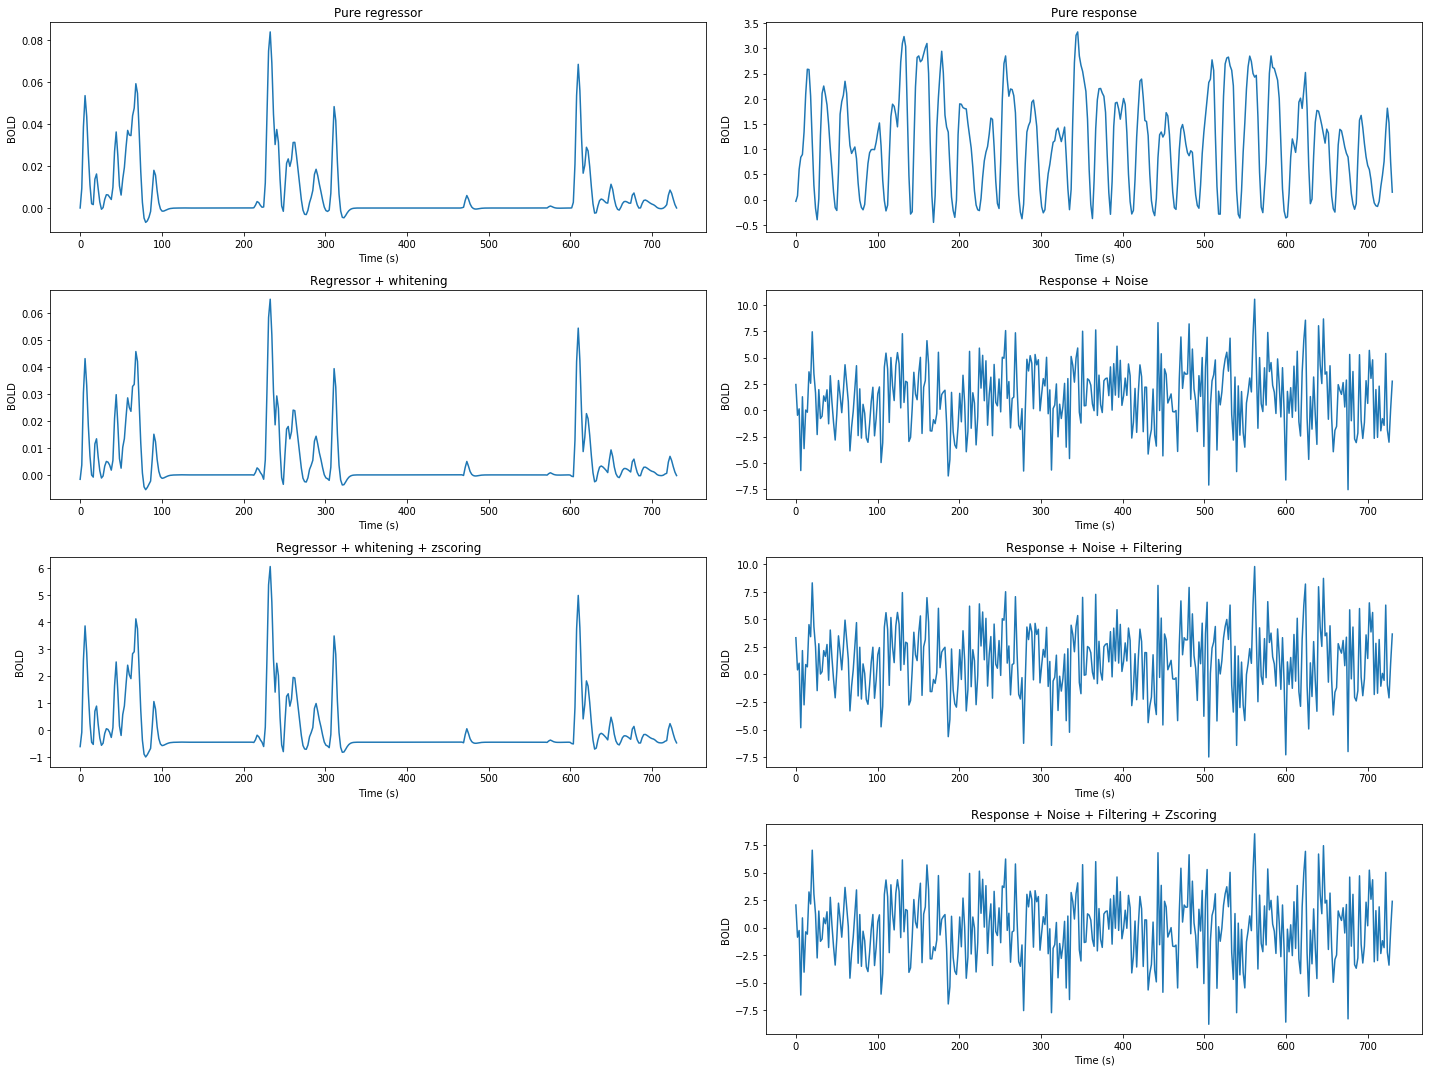

In [38]:
# PICK HERE WHICH REGRESSOR AND RESPONSE TO VISUALIZE
####################################################
k_scheme = 0
k_fraction = 1
k_subject = 0
k_session = 3
i = 1   # Index of the regressor to visualize
####################################################

y1_plot = copy.deepcopy(y_without_noise[k_scheme][k_fraction][k_subject][k_session])
y2_plot = copy.deepcopy(y_with_noise[k_scheme][k_fraction][k_subject][k_session])
y3_plot = copy.deepcopy(y_after_filtering[k_scheme][k_fraction][k_subject][k_session])
y4_plot = copy.deepcopy(yz[k_scheme][k_fraction][k_subject][k_session])

x1_plot = copy.deepcopy(X_before_whitening[k_scheme][k_subject][k_session][:, i])
x2_plot = copy.deepcopy(X_after_whitening[k_scheme][k_subject][k_session][:, i])
x3_plot = copy.deepcopy(Xz[k_scheme][k_subject][k_session][:, i])

fig = plt.figure(figsize=(20, 15))

ax_up = fig.add_subplot(421)
between_scans_time = 2.0
ax_up.set_xlabel('Time (s)')
ax_up.set_ylabel('BOLD')
ax_up.set_title('Pure regressor')
ax_up.plot(np.linspace(0, between_scans_time*len(x1_plot), len(x1_plot)), x1_plot)

ax_down = fig.add_subplot(423)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening')
ax_down.plot(np.linspace(0, between_scans_time*len(x2_plot), len(x2_plot)), x2_plot)

ax_down = fig.add_subplot(425)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening + zscoring')
ax_down.plot(np.linspace(0, between_scans_time*len(x3_plot), len(x3_plot)), x3_plot)

ax1 = fig.add_subplot(422)
ax1.plot(np.linspace(0, between_scans_time*len(y1_plot), len(y1_plot)), y1_plot)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('BOLD')
ax1.set_title('Pure response')

ax2 = fig.add_subplot(424)
ax2.plot(np.linspace(0, between_scans_time*len(y2_plot), len(y2_plot)), y2_plot)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('BOLD')
ax2.set_title('Response + Noise')

ax3 = fig.add_subplot(426)
ax3.plot(np.linspace(0, between_scans_time*len(y3_plot), len(y3_plot)), y3_plot)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('BOLD')
ax3.set_title('Response + Noise + Filtering')

ax4 = fig.add_subplot(428)
ax4.plot(np.linspace(0, between_scans_time*len(y4_plot), len(y4_plot)), y4_plot)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('BOLD')
ax4.set_title('Response + Noise + Filtering + Zscoring')
fig.tight_layout()
plt.show()


## Regression

### Visualization of an example of training and testing

Here we select arbitrary values of hyperparameters and plot the result for one fit.


Fitted scheme : sigmoid_ppc
True scheme = sigmoid_ppc
Subject n°0
Left-out session : 3
r2_true_test = 0.9242954815703792
r2_raw_test = 0.1192170727558195
rho_true_test = 0.9959052080778109
rho_raw_test = 0.34527825410213653


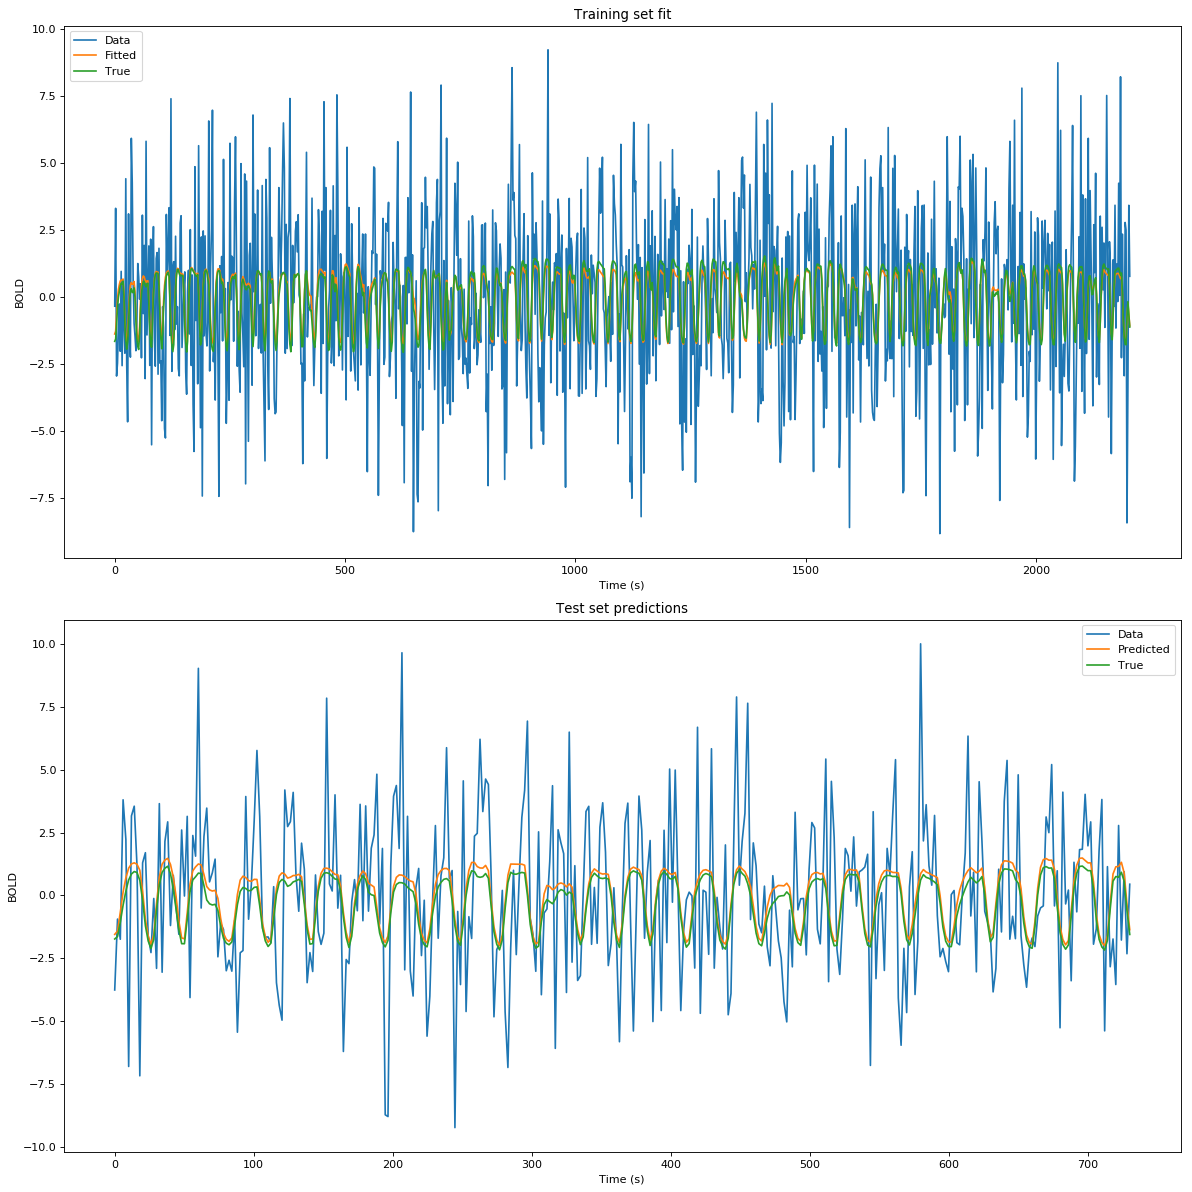

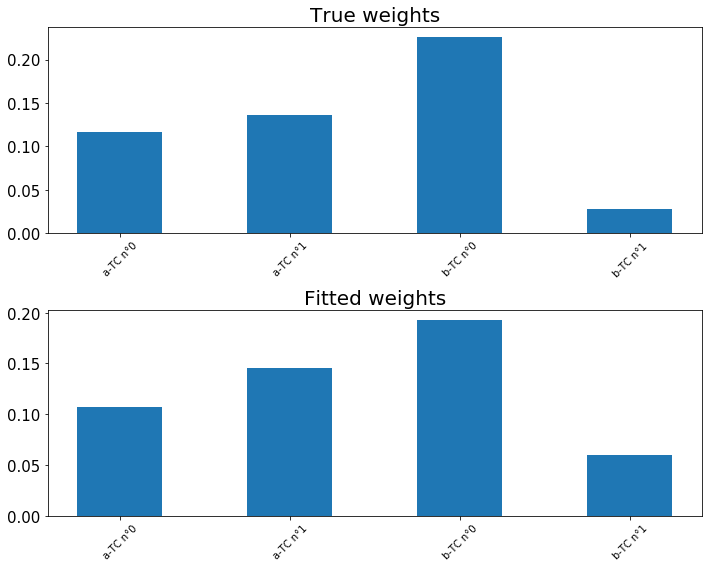

[0.11678577 0.13658334 0.22569757 0.02767154]
[0.10693905 0.14562162 0.19302958 0.05953109]
SNR_eff = 0.11229568380178165


In [39]:
# PICK HERE WHICH MODEL, SET, ETC. TO VISUALIZE
#######################################
k_fit_scheme = 1
k_true_scheme = 1
k_fraction = 0
k_subject = 0
k_session = 3    # Left-out session
#######################################

fit_scheme = scheme_array[k_fit_scheme]
true_scheme = scheme_array[k_true_scheme]

n_fit_features = len(X[k_fit_scheme][0][0][0, :])
n_true_features = len(X[k_true_scheme][0][0][0, :])


print('Fitted scheme : '+fit_scheme+'\n'+'True scheme = '+str(true_scheme)+
      '\n'+'Subject n°'+str(k_subject)+'\nLeft-out session : '+str(k_session))

# Current cross-validation matrice and response
X_cv = copy.deepcopy(Xz[k_fit_scheme][k_subject])
y_cv = copy.deepcopy(yz[k_true_scheme][k_fraction][k_subject])

y_without_noise_cv = copy.deepcopy(yz_without_noise[k_true_scheme][k_fraction][k_subject])

X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))

X_test = copy.deepcopy(X_cv[k_session])
y_test = copy.deepcopy(y_cv[k_session])
y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])


# Train the model using the training set
regr.fit(X_train, y_train)
y_hat_train = regr.predict(X_train)

# Make predictions using the testing set
y_pred = np.transpose(np.array([regr.predict(X_test)]))

# Second fit
regr2.fit(y_pred, y_test)
y_pred2 = regr2.predict(y_pred)

# Train and test results
r2_raw_test_unique = r2_score(y_test, y_pred2)
r2_raw_train_unique = r2_score(y_train, y_hat_train)
rho_raw_train_unique = pearsonr(y_train, y_hat_train)[0]
rho_raw_test_unique = pearsonr(y_test, y_pred2)[0]

r2_true_test_unique = r2_score(y_without_noise_test, y_pred2)
r2_true_train_unique = r2_score(y_without_noise_train, y_hat_train)
rho_true_train_unique = pearsonr(y_without_noise_train, y_hat_train)[0]
rho_true_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

# Plot the signal and the response
fig1 = plt.figure(figsize=(15,15), dpi= 80)
ax_y_train = fig1.add_subplot(211)
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_train), len(y_train)), y_train, label='Data')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_hat_train), len(y_hat_train)), y_hat_train, label='Fitted')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_without_noise_train), len(y_without_noise_train)), y_without_noise_train, label='True')
ax_y_train.legend()
ax_y_train.set_xlabel('Time (s)')
ax_y_train.set_ylabel('BOLD')
ax_y_train.set_title('Training set fit')
# Separate sessions
#print(str(y_cv[0]))
dash_line = [None for k in range(n_sessions-1)]
dash_position = 0
for k in range(n_sessions-1):
    dash_position += between_scans_time*len(y_cv[k])
    dash_line[k] = ax_y_train.plot(dash_position*np.ones(10), np.linspace(-1e-3, 1e-3, 10), color='black', linestyle='--')

ax_y_test = fig1.add_subplot(212)
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_test), len(y_test)), y_test, label='Data')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_pred), len(y_pred)), y_pred2, label='Predicted')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_without_noise_test), len(y_without_noise_test)), y_without_noise_test, label='True')
ax_y_test.legend()
ax_y_test.set_xlabel('Time (s)')
ax_y_test.set_ylabel('BOLD')
ax_y_test.set_title('Test set predictions')
fig1.tight_layout()

print('r2_true_test = '+str(r2_true_test_unique))
print('r2_raw_test = '+str(r2_raw_test_unique))
print('rho_true_test = '+str(rho_true_test_unique))
print('rho_raw_test = '+str(rho_raw_test_unique))

## Plot the weights

true_weights = weights[k_true_scheme][k_fraction][k_subject]
fit_weights = regr.coef_

# Plot the true weights

width = 1/np.sqrt((n_true_features))

fig2 = plt.figure(figsize=(10,8))
ax_true_weights = fig2.add_subplot(211)
labels = [None for k in range(n_true_features)]
for k in range(n_true_features):
    if k<int(n_true_features/2):
        labels[k] = 'a-TC n°'+str(k%int(n_true_features/2))
    else:
        labels[k] = 'b-TC n°'+str(k%int(n_true_features/2))
ax_true_weights.bar(labels, true_weights, width=width)
ax_true_weights.tick_params(labelsize=15)
ax_true_weights.set_title('True weights', fontsize=20)
#ax_true_weights.set_ylim([-1, 1])
ax_true_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_true_weights.axhline(0, color="black", linewidth=1)

width = 1/np.sqrt((n_fit_features))
ax_fit_weights = fig2.add_subplot(212)
labels = [None for k in range(n_fit_features)]
for k in range(n_fit_features):
    if k<int(n_fit_features/2):
        labels[k] = 'a-TC n°'+str(k%int(n_fit_features/2))
    else:
        labels[k] = 'b-TC n°'+str(k%int(n_fit_features/2))
ax_fit_weights.bar(labels, fit_weights, width=width)
ax_fit_weights.tick_params(labelsize=15)
ax_fit_weights.set_title('Fitted weights', fontsize=20)
# ax_fit_weights.set_ylim([-1, 1])
ax_fit_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_fit_weights.axhline(0, color="black", linewidth=1)
fig2.tight_layout()
plt.show()    

print(true_weights)
print(fit_weights)


snr_eff = np.var(y_without_noise_test)/(np.var(y_without_noise_test)+np.var(y_test-y_without_noise_test))
print('SNR_eff = '+str(snr_eff))

### Cross-validation loops (simulation 1)

In [41]:
# The loops
# The quantity to be computed during the cross validation
r2_test = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
r2_train = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
rho_test = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
rho_train = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))

r2_true_test = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
r2_true_train = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
rho_true_test = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))
rho_true_train = np.zeros((n_schemes, n_schemes, n_fractions, n_subjects, n_sessions))

### BEGINNING OF LOOPS OVER HYPERPARAMETERS
for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):
        # Current cross-validation matrix and response
        X_cv = copy.deepcopy(Xz[k_fit_scheme][k_subject])
        y_cv = copy.deepcopy(yz[k_true_scheme][k_fraction][k_subject])
        y_without_noise_cv = copy.deepcopy(yz_without_noise[k_true_scheme][k_fraction][k_subject])

        # LOOP OVER SESSIONS (CV)
        for k_session in range(n_sessions):
            X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
            y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
            X_test = copy.deepcopy(X_cv[k_session])
            y_test = copy.deepcopy(y_cv[k_session])

            y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))
            y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])

            # Train the model using the training set
            regr.fit(X_train, y_train)
            y_hat_train = regr.predict(X_train)
            # Make predictions using the testing set
            y_pred = regr.predict(X_test)
            y_pred_tmp = np.transpose(np.array([y_pred]))

            # Second fit
            regr2.fit(y_pred_tmp, y_test)
            y_pred2 = regr2.predict(y_pred_tmp)

            # Train and test results
            r2_test_unique = r2_score(y_without_noise_test, y_pred2)
            r2_train_unique = r2_score(y_train, y_hat_train)
            rho_train_unique = pearsonr(y_train, y_hat_train)[0]
            rho_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

            r2_train[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = r2_score(y_train, y_hat_train)
            r2_test[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = r2_score(y_test, y_pred2)
            rho_train[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = pearsonr(y_train, y_hat_train)[0]
            rho_test[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = pearsonr(y_test, y_pred2)[0]
            rho_true_train[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = pearsonr(y_without_noise_train, y_hat_train)[0]
            rho_true_test[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = pearsonr(y_without_noise_test, y_pred2)[0]

            r2_true_train[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = r2_score(y_without_noise_train, y_hat_train)

            r2_true_test[k_fit_scheme, k_true_scheme, k_fraction, k_subject, k_session] \
                = r2_score(y_without_noise_test, y_pred2)
    print('Scheme n'+str(k_true_scheme)+' fitted with scheme n'+str(k_fit_scheme)+'.')


Scheme n0 fitting with scheme n0 done.
Scheme n1 fitting with scheme n0 done.
Scheme n2 fitting with scheme n0 done.
Scheme n3 fitting with scheme n0 done.
Scheme n4 fitting with scheme n0 done.
Scheme n0 fitting with scheme n1 done.
Scheme n1 fitting with scheme n1 done.
Scheme n2 fitting with scheme n1 done.
Scheme n3 fitting with scheme n1 done.
Scheme n4 fitting with scheme n1 done.
Scheme n0 fitting with scheme n2 done.
Scheme n1 fitting with scheme n2 done.
Scheme n2 fitting with scheme n2 done.
Scheme n3 fitting with scheme n2 done.
Scheme n4 fitting with scheme n2 done.
Scheme n0 fitting with scheme n3 done.
Scheme n1 fitting with scheme n3 done.
Scheme n2 fitting with scheme n3 done.
Scheme n3 fitting with scheme n3 done.
Scheme n4 fitting with scheme n3 done.
Scheme n0 fitting with scheme n4 done.
Scheme n1 fitting with scheme n4 done.
Scheme n2 fitting with scheme n4 done.
Scheme n3 fitting with scheme n4 done.
Scheme n4 fitting with scheme n4 done.


## Handle the data

### Row data loading and visualization


In [42]:
# Some reloading (run that if the loops have already been performed and results saved)
# r2_test = np.load('output/results2/'+distrib_type+'/r2_test_snr'+str(snr)+'.npy')
# r2_true_test = np.load('output/results2/'+distrib_type+'/r2_true_test_snr'+str(snr)+'.npy')
# r2_train = np.load('output/results2/'+distrib_type+'/r2_train_snr'+str(snr)+'.npy')
# rho_test = np.load('output/results2/'+distrib_type+'/rho_test_snr'+str(snr)+'.npy')
# rho_train = np.load('output/results2/'+distrib_type+'/rho_train_snr'+str(snr)+'.npy')
# r2_true_train = np.load('output/results2/'+distrib_type+'/r2_true_train_snr'+str(snr)+'.npy')
# rho_true_test = np.load('output/results2/'+distrib_type+'/rho_true_test_snr'+str(snr)+'.npy')
# rho_true_train = np.load('output/results2/'+distrib_type+'/rho_true_train_snr'+str(snr)+'.npy')

#np.save('output/results2/r2_test_snr'+str(snr)+'.npy', r2_test)
#np.save('output/results2/r2_true_test_snr'+str(snr)+'.npy', r2_true_test)
#np.save('output/results2/r2_train_snr'+str(snr)+'.npy', r2_train)
#np.save('output/results2/rho_test_snr'+str(snr)+'.npy', rho_test)
#np.save('output/results2/rho_train_snr'+str(snr)+'.npy', rho_train)
#np.save('output/results2/r2_true_train_snr'+str(snr)+'.npy', r2_true_train)
#np.save('output/results2/rho_true_test_snr'+str(snr)+'.npy', rho_true_test)
#np.save('output/results2/rho_true_train_snr'+str(snr)+'.npy', rho_true_train)

r2_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))

# To visualize the impact of the sparsity of the voxel
all_idx = range(20)
bal_idx = [0, 4, 8, 12, 16]
sparse_idx = [3, 7, 11, 15, 19]
n_sparse_fractions = len(sparse_idx)
n_bal_fractions = len(bal_idx)

r2_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes,n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))

r2_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))



for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):
    
    r2_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    
    r2_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()

    r2_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()



### Visualize results from simulation 2 (one example)

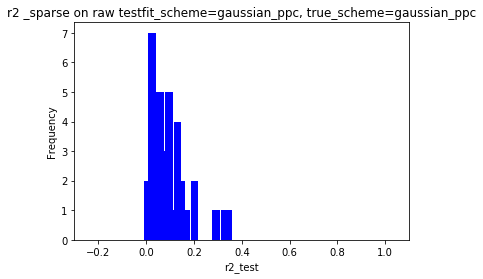

r2 var: 0.007032433223290824
r2 mean: 0.0992273659555813


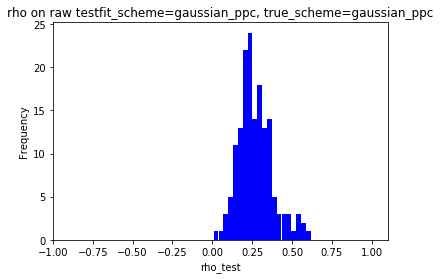

rho var: 0.011484616187324484
rho mean: 0.2853115683707552



In [43]:
# Visualize one specific plot

#########################################
k_fit_scheme = 0
k_true_scheme = 0
##########################################

fit_scheme = scheme_array[k_fit_scheme]
true_scheme = scheme_array[k_true_scheme]

#r2
metric_name = 'r2'
true_or_raw = 'raw'
sparse_or_bal = '_sparse'
train_or_test = 'test'
exec("metric = %s%s_%s_%s_summary[k_fit_scheme, k_true_scheme, :]" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))

# # We set the negative r2 to the same value
# negative_center = -0.2
# n_negative_values = 0
# if metric_name.find('r2')!=-1:
#     for k, metric_value in enumerate(metric):
#         if metric_value <0:
#             metric[k] = negative_center
#             n_negative_values += 1

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
#ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' '+sparse_or_bal+' on '+true_or_raw+' '+train_or_test+'fit_scheme='+fit_scheme+', true_scheme='+true_scheme)
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

# rho
metric_name = 'rho'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_fit_scheme, k_true_scheme]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.set_title(metric_name+' on '+true_or_raw+' '+train_or_test+'fit_scheme='+fit_scheme+', true_scheme='+true_scheme)
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))
print()

## Plot confusion matrices for simulation 2

r2 on raw test set


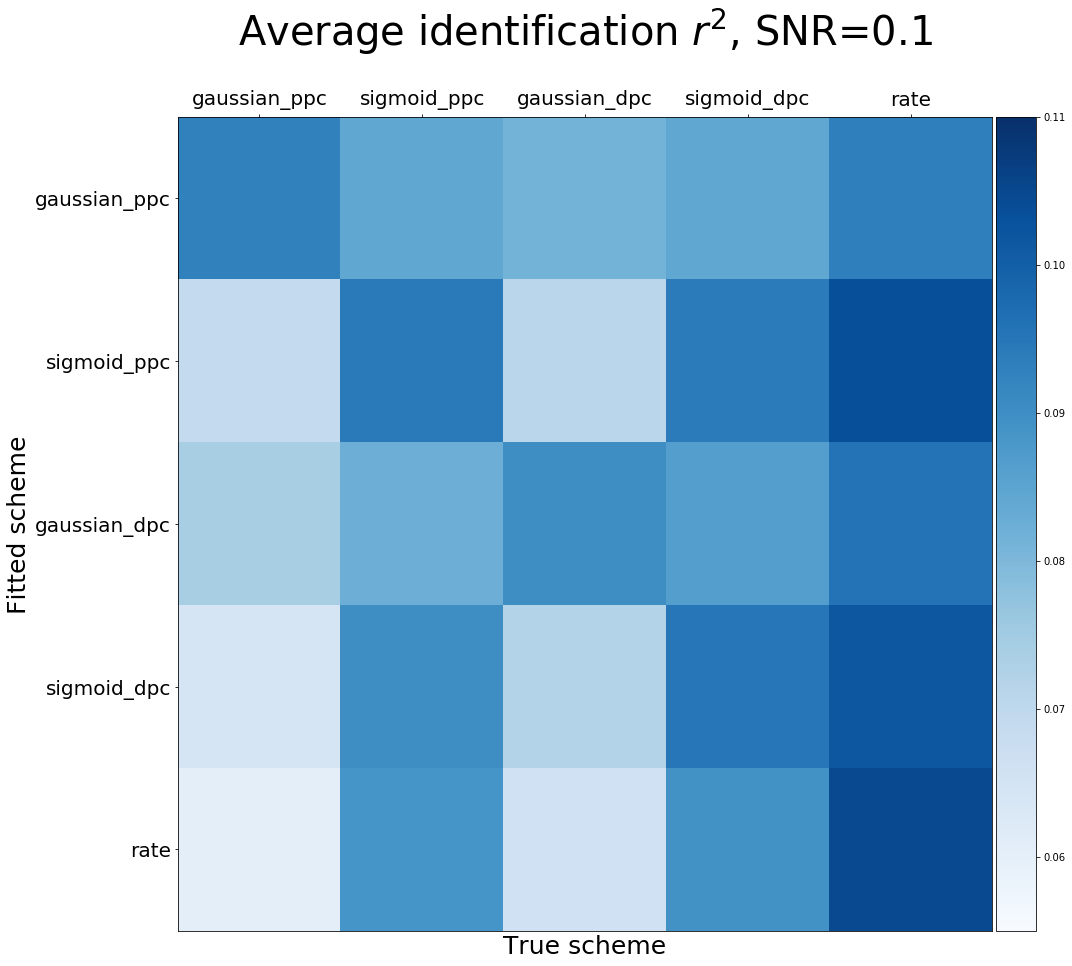

In [45]:
################################

metric_name = 'r2'
true_or_raw = 'raw'
sparse_or_bal = ''
train_or_test = 'test'

print(metric_name+' on '+true_or_raw+' '+train_or_test+' set')

# Visualize the entire confusion matrix
nbins = 20
width = 0.05

# Plot the confusion matrix of the mean
column_labels = scheme_array
row_labels = scheme_array

min_colorbar = 0.055
max_colorbar = 0.11


fig, ax = plt.subplots(figsize=(15,15))
fontsize = 15
exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))
# We set the negative r2 to the same value
data = np.mean(metric, axis=2)
heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=min_colorbar, vmax=max_colorbar)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize+5)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize+5)
ax.set_ylabel('Fitted scheme', fontsize=fontsize+10)
ax.set_xlabel('True scheme', fontsize=fontsize+10)
plt.title('Average identification $r^2$, SNR='+str(snr), y=1.08, fontsize=40)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
fig.tight_layout()
plt.show()

#fig.savefig("figures_tmp/"+distrib_type+"_simu2_fit_{}{}_{}_{}".format(metric_name, sparse_or_bal, true_or_raw, train_or_test), bbox_inches='tight')


In [46]:
# Visualize the percentage of hits

metric_name = 'r2'
true_or_raw = 'raw'
sparse_or_bal = ''
train_or_test = 'test'
exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))


if sparse_or_bal=='_sparse':
    n_trials = n_sparse_fractions*n_subjects*n_sessions
elif sparse_or_bal=='_bal':
    n_trials = n_bal_fractions*n_subjects*n_sessions
else:
    n_trials = n_fractions*n_subjects*n_sessions

hits = np.zeros((n_schemes, n_schemes))
for k_true_scheme in range(n_schemes):
    for k in range(n_trials):
        best_k_fit_scheme = np.argmax(metric[:, k_true_scheme, k])
        #print(best_k_fit_scheme)
        hits[best_k_fit_scheme, k_true_scheme] += 1 

hits = hits/n_trials


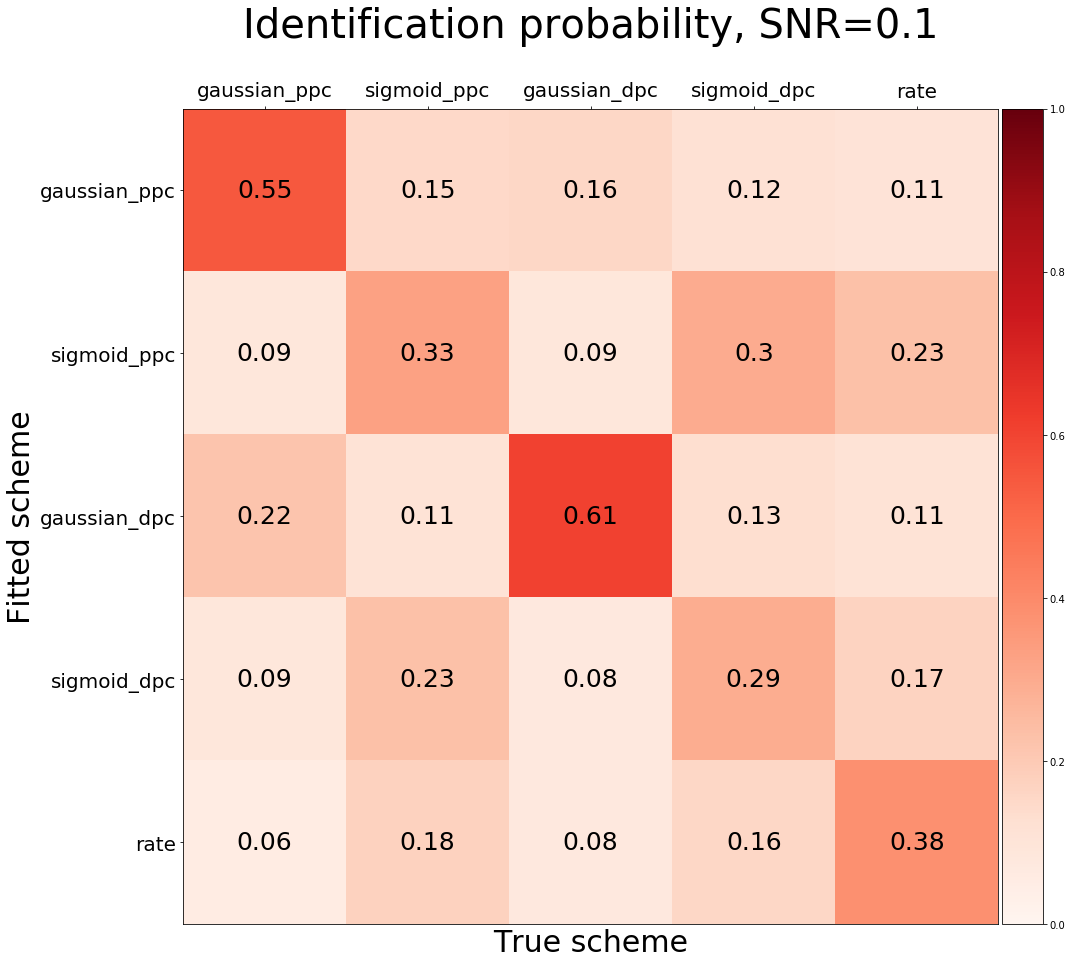

In [47]:
# Plot the identifiability confusion matrix
column_labels = scheme_array
row_labels = scheme_array

fig, ax = plt.subplots(figsize=(15,15))
fontsize = 20

# We set the negative r2 to the same value
data = copy.deepcopy(hits)

min_colormap = 0
max_colormap = 1

heatmap = ax.pcolor(data, cmap=plt.cm.Reds, vmin=min_colormap, vmax=max_colormap)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('Fitted scheme', fontsize=fontsize+10)
ax.set_xlabel('True scheme', fontsize=fontsize+10)
plt.title('Identification probability, SNR='+str(snr), y=1.08, fontsize=40)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(heatmap, cax=cax)

for i in range(n_schemes):
    for j in range(n_schemes):
        c = round(hits[j,i], 2)
        ax.text(i+0.5, j+0.5, str(c), va='center', ha='center', fontsize = 25)

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

fig.tight_layout()
plt.show()

#fig.savefig("figures_tmp/"+distrib_type+"_simu2_proba_{}{}_{}_{}".format(metric_name, sparse_or_bal, true_or_raw, train_or_test), bbox_inches='tight')


### Differences between both identifiability matrices

In [48]:
distrib_type = 'transition'
# Some reloading (run that if the loops have already been performed and results saved)
r2_test = np.load('output/results2/'+distrib_type+'/r2_test_snr'+str(snr)+'.npy')
r2_true_test = np.load('output/results2/'+distrib_type+'/r2_true_test_snr'+str(snr)+'.npy')
r2_train = np.load('output/results2/'+distrib_type+'/r2_train_snr'+str(snr)+'.npy')
rho_test = np.load('output/results2/'+distrib_type+'/rho_test_snr'+str(snr)+'.npy')
rho_train = np.load('output/results2/'+distrib_type+'/rho_train_snr'+str(snr)+'.npy')
r2_true_train = np.load('output/results2/'+distrib_type+'/r2_true_train_snr'+str(snr)+'.npy')
rho_true_test = np.load('output/results2/'+distrib_type+'/rho_true_test_snr'+str(snr)+'.npy')
rho_true_train = np.load('output/results2/'+distrib_type+'/rho_true_train_snr'+str(snr)+'.npy')

r2_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))

all_idx = range(20)
n_sparse_fractions = len(sparse_idx)
n_bal_fractions = len(bal_idx)

r2_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes,n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))

r2_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))

for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):
    
    r2_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    
    r2_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()

    r2_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()


# Visualize the percentage of hits

exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))

if sparse_or_bal=='_sparse':
    n_trials = n_sparse_fractions*n_subjects*n_sessions
elif sparse_or_bal=='_bal':
    n_trials = n_bal_fractions*n_subjects*n_sessions
else:
    n_trials = n_fractions*n_subjects*n_sessions

hits = np.zeros((n_schemes, n_schemes))
for k_true_scheme in range(n_schemes):
    for k in range(n_trials):
        best_k_fit_scheme = np.argmax(metric[:, k_true_scheme, k])
        hits[best_k_fit_scheme, k_true_scheme] += 1 

transition_hits = copy.deepcopy(hits/n_trials)

    
distrib_type = 'bernoulli'
# Some reloading (run that if the loops have already been performed and results saved)
r2_test = np.load('output/results2/'+distrib_type+'/r2_test_snr'+str(snr)+'.npy')
r2_true_test = np.load('output/results2/'+distrib_type+'/r2_true_test_snr'+str(snr)+'.npy')
r2_train = np.load('output/results2/'+distrib_type+'/r2_train_snr'+str(snr)+'.npy')
rho_test = np.load('output/results2/'+distrib_type+'/rho_test_snr'+str(snr)+'.npy')
rho_train = np.load('output/results2/'+distrib_type+'/rho_train_snr'+str(snr)+'.npy')
r2_true_train = np.load('output/results2/'+distrib_type+'/r2_true_train_snr'+str(snr)+'.npy')
rho_true_test = np.load('output/results2/'+distrib_type+'/rho_true_test_snr'+str(snr)+'.npy')
rho_true_train = np.load('output/results2/'+distrib_type+'/rho_true_train_snr'+str(snr)+'.npy')

r2_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))

all_idx = range(20)

#sparse_idx = [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19]
#sparse_idx = [2, 3, 6, 7, 10, 11, 14, 15, 18, 19]
#sparse_idx = [3, 7, 11, 15, 19]
#bal_idx = [item for item in all_idx if item not in sparse_idx]
bal_idx = [0, 4, 8, 12, 16]
sparse_idx = [3, 7, 11, 15, 19]

n_sparse_fractions = len(sparse_idx)
n_bal_fractions = len(bal_idx)

r2_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes,n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))

r2_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))



for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):
    
    r2_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    
    r2_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()

    r2_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()

    
exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))

if sparse_or_bal=='_sparse':
    n_trials = n_sparse_fractions*n_subjects*n_sessions
elif sparse_or_bal=='_bal':
    n_trials = n_bal_fractions*n_subjects*n_sessions
else:
    n_trials = n_fractions*n_subjects*n_sessions

hits = np.zeros((n_schemes, n_schemes))
for k_true_scheme in range(n_schemes):
    for k in range(n_trials):
        best_k_fit_scheme = np.argmax(metric[:, k_true_scheme, k])
        #print(best_k_fit_scheme)
        hits[best_k_fit_scheme, k_true_scheme] += 1 

bernoulli_hits = copy.deepcopy(hits/n_trials)


FileNotFoundError: [Errno 2] No such file or directory: 'output/results2/transition/r2_test_snr0.1.npy'

NameError: name 'transition_hits' is not defined

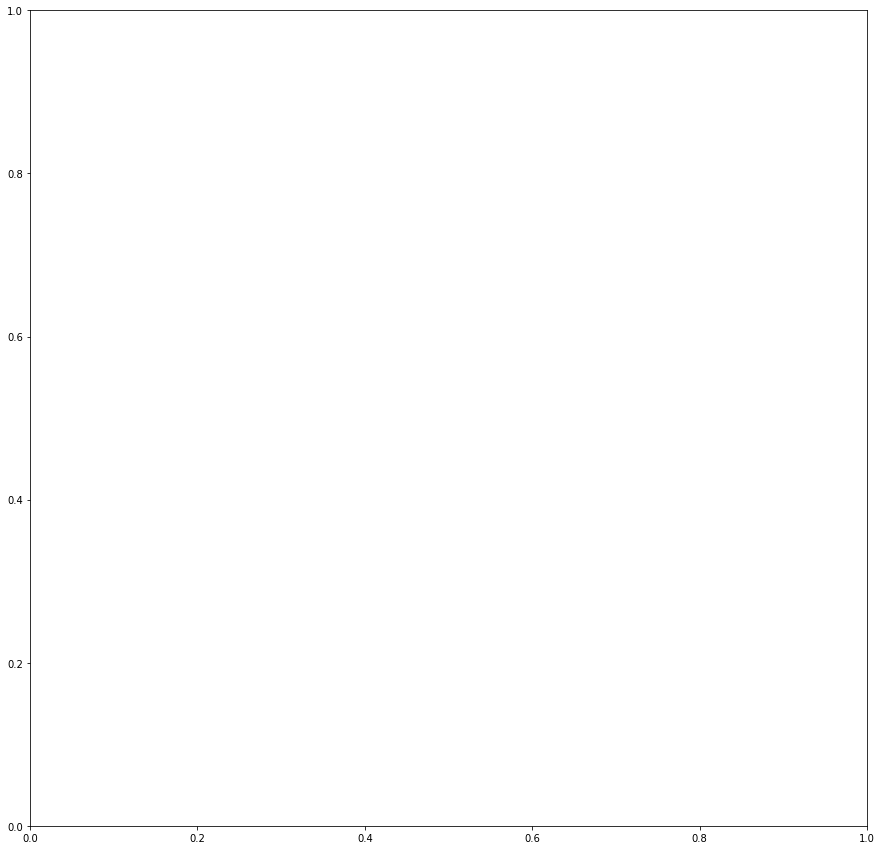

In [49]:
# Plot the confusion matrix of the mean
column_labels = scheme_array
row_labels = scheme_array

fig, ax = plt.subplots(figsize=(15,15))
fontsize = 20

# We set the negative r2 to the same value
data = copy.deepcopy(transition_hits-bernoulli_hits)

min_colormap = -0.1
max_colormap = 0.1

heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn, vmin=min_colormap, vmax=max_colormap)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('Fitted scheme', fontsize=fontsize+10)
ax.set_xlabel('True scheme', fontsize=fontsize+10)
plt.title('Comparison Transition - Bernoulli, SNR='+str(snr), y=1.08, fontsize=40)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(heatmap, cax=cax)

for i in range(n_schemes):
    for j in range(n_schemes):
        c = round(data[j,i], 2)
        ax.text(i+0.5, j+0.5, str(c), va='center', ha='center', fontsize = 25)

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

fig.tight_layout()
plt.show()

#fig.savefig("figures_tmp/comparison_simu2_proba_{}{}_{}_{}".format(metric_name, sparse_or_bal, true_or_raw, train_or_test), bbox_inches='tight')


### Find the optimal number of subjects to be generated,

Plot the mean and variance of these distributions for different number of subject

In [22]:
# Find the assymptotical value for n_fractions
n_subjects_array = np.linspace(1, n_subjects, num=int(n_subjects/5), endpoint=True).astype(int)

subject_r2_train_mean = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))
subject_r2_train_var = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))

subject_r2_test_mean = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))
subject_r2_test_var = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))

subject_r2_true_test_mean = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))
subject_r2_true_test_var = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))

subject_rho_train_mean = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))
subject_rho_train_var = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))

subject_rho_test_mean = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))
subject_rho_test_var = np.zeros((n_schemes, n_schemes, len(n_subjects_array)))

for k_n_subjects, n_subjects in enumerate(n_subjects_array):
    for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):            
        subject_r2_train_mean[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.mean(r2_train[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        subject_r2_train_var[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.var(r2_train[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
                                      
        subject_r2_test_mean[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.mean(r2_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        subject_r2_test_var[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.var(r2_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        
        subject_r2_true_test_mean[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.mean(r2_true_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        subject_r2_true_test_var[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.var(r2_true_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())

        subject_rho_train_mean[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.mean(rho_train[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        subject_rho_train_var[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.var(rho_train[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())

        subject_rho_test_mean[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.mean(rho_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())
        subject_rho_test_var[k_fit_scheme, k_true_scheme, k_n_subjects] = \
            np.var(rho_test[k_fit_scheme, k_true_scheme, :, :n_subjects, :].flatten())


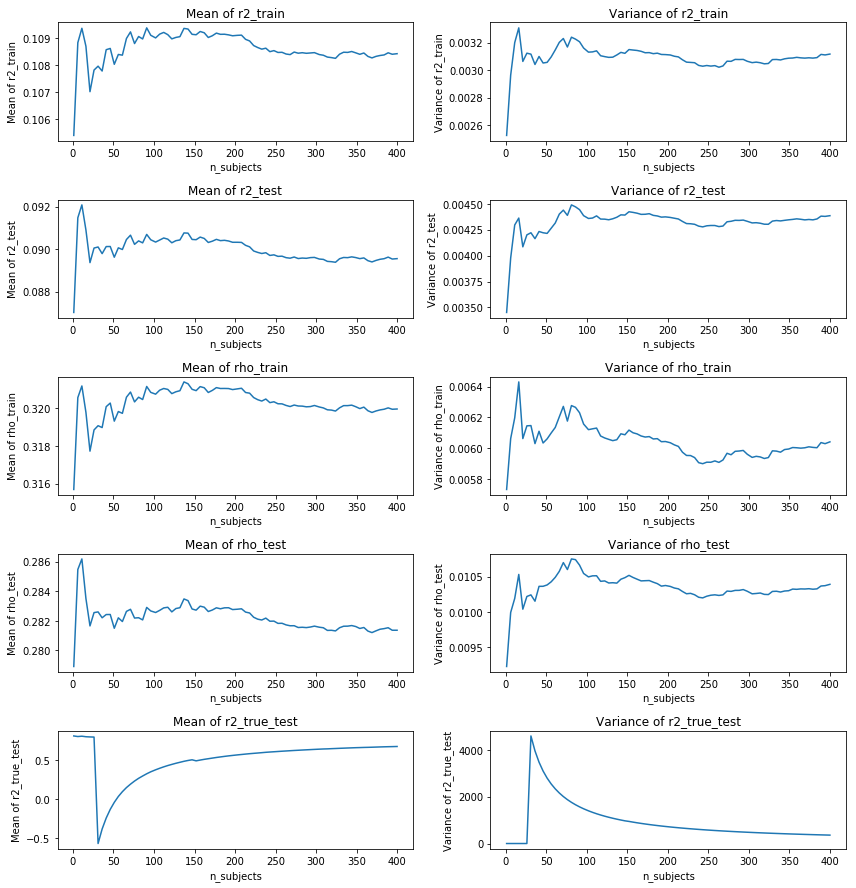

In [23]:
# Visualize the evolution of r2 according to the number of subjects
#n_subjects = 1000
k_fit_scheme = 0
k_true_scheme = 0

subject_r2_train_mean_to_plot = subject_r2_train_mean[k_fit_scheme, k_true_scheme, :]
subject_r2_train_var_to_plot = subject_r2_train_var[k_fit_scheme, k_true_scheme, :]

subject_r2_test_mean_to_plot = subject_r2_test_mean[k_fit_scheme, k_true_scheme, :]
subject_r2_test_var_to_plot = subject_r2_test_var[k_fit_scheme, k_true_scheme, :]

subject_rho_train_mean_to_plot = subject_rho_train_mean[k_fit_scheme, k_true_scheme, :]
subject_rho_train_var_to_plot = subject_rho_train_var[k_fit_scheme, k_true_scheme, :]

subject_rho_test_mean_to_plot = subject_rho_test_mean[k_fit_scheme, k_true_scheme, :]
subject_rho_test_var_to_plot = subject_rho_test_var[k_fit_scheme, k_true_scheme, :]

subject_r2_true_test_mean_to_plot = subject_r2_true_test_mean[k_fit_scheme, k_true_scheme, :]
subject_r2_true_test_var_to_plot = subject_r2_true_test_var[k_fit_scheme, k_true_scheme, :]

fig = plt.figure(figsize=(12, 12))
ax_r2_train_mean = fig.add_subplot(521)
ax_r2_train_mean.plot(n_subjects_array, subject_r2_train_mean_to_plot)
ax_r2_train_mean.set_xlabel('n_subjects')
ax_r2_train_mean.set_ylabel('Mean of r2_train')
ax_r2_train_mean.set_title('Mean of r2_train')

ax_r2_train_var = fig.add_subplot(522)
ax_r2_train_var.plot(n_subjects_array, subject_r2_train_var_to_plot)
ax_r2_train_var.set_xlabel('n_subjects')
ax_r2_train_var.set_ylabel('Variance of r2_train')
ax_r2_train_var.set_title('Variance of r2_train')

ax_r2_test_mean = fig.add_subplot(523)
ax_r2_test_mean.plot(n_subjects_array, subject_r2_test_mean_to_plot)
ax_r2_test_mean.set_xlabel('n_subjects')
ax_r2_test_mean.set_ylabel('Mean of r2_test')
ax_r2_test_mean.set_title('Mean of r2_test')

ax_r2_test_var = fig.add_subplot(524)
ax_r2_test_var.plot(n_subjects_array, subject_r2_test_var_to_plot)
ax_r2_test_var.set_xlabel('n_subjects')
ax_r2_test_var.set_ylabel('Variance of r2_test')
ax_r2_test_var.set_title('Variance of r2_test')

ax_rho_train_mean = fig.add_subplot(525)
ax_rho_train_mean.plot(n_subjects_array, subject_rho_train_mean_to_plot)
ax_rho_train_mean.set_xlabel('n_subjects')
ax_rho_train_mean.set_ylabel('Mean of rho_train')
ax_rho_train_mean.set_title('Mean of rho_train')

ax_rho_train_var = fig.add_subplot(526)
ax_rho_train_var.plot(n_subjects_array, subject_rho_train_var_to_plot)
ax_rho_train_var.set_xlabel('n_subjects')
ax_rho_train_var.set_ylabel('Variance of rho_train')
ax_rho_train_var.set_title('Variance of rho_train')

ax_rho_test_mean = fig.add_subplot(527)
ax_rho_test_mean.plot(n_subjects_array, subject_rho_test_mean_to_plot)
ax_rho_test_mean.set_xlabel('n_subjects')
ax_rho_test_mean.set_ylabel('Mean of rho_test')
ax_rho_test_mean.set_title('Mean of rho_test')

ax_rho_test_var = fig.add_subplot(528)
ax_rho_test_var.plot(n_subjects_array, subject_rho_test_var_to_plot)
ax_rho_test_var.set_xlabel('n_subjects')
ax_rho_test_var.set_ylabel('Variance of rho_test')
ax_rho_test_var.set_title('Variance of rho_test')
fig.tight_layout()

ax_r2_true_test_mean = fig.add_subplot(5,2, 9)
ax_r2_true_test_mean.plot(n_subjects_array, subject_r2_true_test_mean_to_plot)
ax_r2_true_test_mean.set_xlabel('n_subjects')
ax_r2_true_test_mean.set_ylabel('Mean of r2_true_test')
ax_r2_true_test_mean.set_title('Mean of r2_true_test')

ax_r2_true_test_var = fig.add_subplot(5,2,10)
ax_r2_true_test_var.plot(n_subjects_array, subject_r2_true_test_var_to_plot)
ax_r2_true_test_var.set_xlabel('n_subjects')
ax_r2_true_test_var.set_ylabel('Variance of r2_true_test')
ax_r2_true_test_var.set_title('Variance of r2_true_test')


plt.show()